## Policy Playground  
This is code for loading and testing saved policies.  
The model 'Policy_2H300P_63CS' was the best policy iteration after a few thousand iterations of training.  
It did not perform as well as scripted policies (see /P2_Environment/RNN_DDPG/test_rnn_env.ipynb).  
All runs were done with 2 Herds and a total population of 300.

In [1]:
import tensorflow as tf
import numpy as np

import tensorflow_probability as tfp
from tf_agents.environments import tf_py_environment
from tf_agents.policies import scripted_py_policy

import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
#plt.ioff() 

from RNN_Env_P2 import Env_P2_N

In [2]:
max_episode_length=1000
num_herds = 2   ## plotting currently only works for 2 herds
total_population = 300

saved_pol = tf.compat.v2.saved_model.load('Policy_2H300P_63CS')
py_env = Env_P2_N(num_herds = num_herds, total_population = total_population)
eval_tf_env = tf_py_environment.TFPyEnvironment(py_env)

In [3]:
def test_policy(environment, policy, num_episodes=50):
    if isinstance(environment, tf_py_environment.TFPyEnvironment):
        total_return = 0.0
        cullsteps = 0 
        actions = []
        for e in range(num_episodes):

            time_step = environment.reset()
            if isinstance(policy, scripted_py_policy.ScriptedPyPolicy):
                policy_state = policy.get_initial_state() # remember where in the script we were
            else:
                #print(policy.get_initial_state(batch_size=train_env.batch_size()))
                policy_state = policy.get_initial_state(batch_size=1) # other policies without memory
            episode_return = 0.0
            i=0
            while not time_step.is_last():
                i+=1
                action_step = policy.action(time_step, policy_state)
                for i in range (num_herds, num_herds*2):
                    if action_step.action[0][i] > 0:
                        cullsteps += 1
                        break
                if e == np.int32(num_episodes/2):
                    actions.append(action_step.action[0])
                policy_state = action_step.state
                time_step = environment.step(action_step.action)
                episode_return += time_step.reward

            total_return += episode_return

        avg_return = total_return / num_episodes
        cullsteps /= num_episodes
        return avg_return, cullsteps, actions
    else:
        return None

In [7]:
 def plot_actions(action_list):
        t = np.linspace(0, len(action_list)+10, num=len(action_list))
        fig, (p1,p2) = plt.subplots(1, 2, figsize=(10,7))
        fig.suptitle('Actions over Time')
        p1.set_title('Tests over Time')
        p1.set_xlabel('Time')
        p1.set_ylabel('Number of Tests')
        p1.set_ylim(-0.2, (total_population/num_herds)+1)
        p2.set_title('Herd Replacements over Time')
        p2.set_xlabel('Time')
        p2.set_ylabel('Replacement Probability')
        p2.set_ylim(-0.2, 1.2) 
        n_tests_h1, n_tests_h2, replace_h1, replace_h2 = [], [], [], []
        for i in range(len(action_list)):
            n_tests_h1.append(action_list[i][0])
            n_tests_h2.append(action_list[i][1])
            replace_h1.append(action_list[i][2])
            replace_h2.append(action_list[i][3])
        p1.plot(t, n_tests_h1, color='grey', label = 'Herd 1', marker = '', linestyle = '-')
        p1.plot(t, n_tests_h2, color='blue', label = 'Herd 2', marker = '', linestyle = '-')
        p2.plot(t, replace_h1, color='grey', label = 'Herd 1', marker = '', linestyle = '-')
        p2.plot(t, replace_h2, color='blue', label = 'Herd 2', marker = '', linestyle = '-')
        p1.legend()
        p2.legend()
        return fig

In [5]:
ret, cull, act = test_policy(eval_tf_env, saved_pol, num_episodes = 200)
fig = plot_actions(act)

NameError: name 'self' is not defined

Average Return:  tf.Tensor([-29301.148], shape=(1,), dtype=float32)
Cullsteps:  74.435
First 30 Actions:  [<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.0000000e+00, 0.0000000e+00, 1.9729137e-05, 3.0884147e-04],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=
array([9.9999869e-01, 0.0000000e+00, 1.1920929e-07, 8.4833777e-01],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=
array([9.9986887e-01, 0.0000000e+00, 1.1265278e-05, 9.9996793e-01],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.7702490e-02, 0.0000000e+00, 1.7881393e-06, 9.9999577e-01],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.00034431, 0.        , 0.        , 0.        ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=
array([2.9877126e-03, 5.9604645e-07, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=
array([4.2506754e-03, 1.9967556e-06, 0.00000

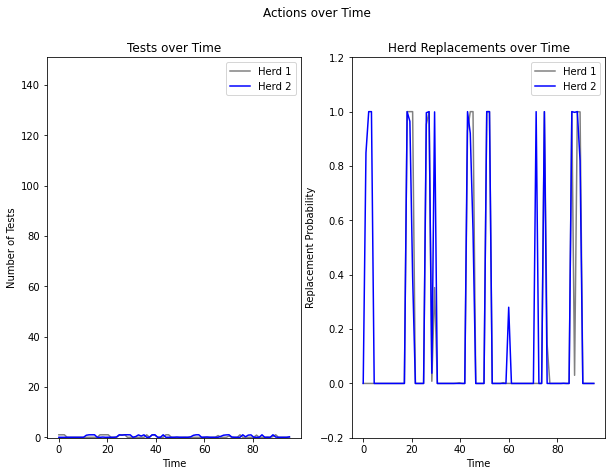

In [8]:
fig = plot_actions(act)
print('Average Return: ', ret)
print('Cullsteps: ', cull)
print('First 30 Actions: ', act[:29])
plt.show()